# 1. Nettoyer le jeu
# 2. Modèle ML

~~~~
Capteur:
* InletTemp-sensor
* SetTemp-sensor
* Drive-sensor
* Mode-sensor
~~~~

### 1. Nettoyer le jeu
* Exploration des colonnes et drop des non nécessaires
* Noter les intervalles ou listes pour chaque capteur
* Features engineering (transformation des dates, merges, etc...)
* Exclure les outliers n'étant pas dans les intervalles ou listes
* Vérifier la présence de doublons
* Exploration des données

### 2. Modèle ML
* Modèle de Régression:
  * RandomTreeRegressor
  * Gradient Boosting (linéaire, tree)
  * KernelRidge (linéaire, rbf, etc...)
* Modèle de Classification?:
  * Chaque classe étant les n-entiers dans l'intervalles des valeurs de SetTemp-sensor
  * Valeurs continues dans classification?

## 1. Nettoyer le jeu

In [1]:
import sqlalchemy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)


In [2]:
from sqlalchemy  import create_engine

db_type = "mysql"
driver = "mysqlconnector"
login = "root"
password = "MYSQLR00tP455w0rd!!!"
host = "localhost"
db_name = "client_main"

engine = create_engine(f"{db_type}+{driver}://{login}:{password}@{host}/{db_name}")

measures_query = "SELECT * FROM DataMeasurements"
sensors_query = "SELECT * FROM Sensors"

measures_df = pd.read_sql(measures_query, engine)
sensors_df = pd.read_sql(sensors_query, engine)

### * Exploration des colonnes

In [3]:
sensors_df.head(10)

,SensorId,Name,Technical_Name,DataTypeId,UnitId,Active,EquipmentId,FatherId,IdLocal_Hub,SubType,Min,Max,List,TransmissionMode,DirectUrl,BoxId,IdLocal_Setup
0,1,InletTemp-sensor,InletTemp-sensor,227,3,1,1,None,None,numeric,16.0,32.0,None,history,None,None,None
1,2,SetTemp-sensor,SetTemp-sensor,226,3,1,1,None,None,numeric,16.0,32.0,None,history,None,None,None
2,3,Drive-sensor,Drive-sensor,228,8,1,1,None,None,binary,NaN,NaN,0|0;2|2,history,None,None,None
3,4,FanSpeed-sensor,FanSpeed-sensor,255,8,1,1,None,None,number,NaN,NaN,3003|3003;3005|3005,history,None,None,None
4,5,Mode-sensor,Mode-sensor,225,8,1,1,None,None,select,NaN,NaN,COOL|COOL;HEAT|HEAT;FAN|FAN,history,None,None,None
5,6,ErrCode-sensor,ErrCode-sensor,267,8,1,1,None,None,string,NaN,NaN,None,history,None,None,None
6,7,InletTemp-sensor,InletTemp-sensor,227,3,1,2,None,None,numeric,16.0,32.0,None,history,None,None,None
7,8,SetTemp-sensor,SetTemp-sensor,226,3,1,2,None,None,numeric,16.0,32.0,None,history,None,None,None
8,9,Drive-sensor,Drive-sensor,228,8,1,2,None,None,binary,NaN,NaN,0|0;2|2,history,None,None,None
9,10,FanSpeed-sensor,FanSpeed-sensor,255,8,1,2,None,None,number,NaN,NaN,3003|3003;3005|3005,history,None,None,None


In [4]:
sensors_df.drop(["Technical_Name", "DataTypeId", "UnitId", "Active", "FatherId", "IdLocal_Hub", 
    "SubType", "TransmissionMode", "DirectUrl", "BoxId", "IdLocal_Setup"], axis= 1, inplace= True)

sensors_df

,SensorId,Name,EquipmentId,Min,Max,List
0,1,InletTemp-sensor,1,16.0,32.0,None
1,2,SetTemp-sensor,1,16.0,32.0,None
2,3,Drive-sensor,1,NaN,NaN,0|0;2|2
3,4,FanSpeed-sensor,1,NaN,NaN,3003|3003;3005|3005
4,5,Mode-sensor,1,NaN,NaN,COOL|COOL;HEAT|HEAT;FAN|FAN
...,...,...,...,...,...,...
109,110,SetTemp-sensor,19,16.0,32.0,None
110,111,Drive-sensor,19,NaN,NaN,0|0;2|2
111,112,FanSpeed-sensor,19,NaN,NaN,3009|3009;3011|3011;3013|3013
112,113,Mode-sensor,19,NaN,NaN,COOL|COOL;HEAT|HEAT;FAN|FAN


In [5]:
measures_df

,DataMeasurementId,DateTime,SensorId,Value,Raw
0,1,2021-10-18 10:13:28.415,1,19.1,19.1
1,2,2021-10-18 10:13:28.446,2,29.0,29.0
2,3,2021-10-18 10:13:28.469,4,4.0,3005
3,4,2021-10-18 10:13:28.481,5,2.0,HEAT
4,5,2021-10-18 10:13:28.492,7,22.5,22.5
...,...,...,...,...,...
68085,68086,2021-11-21 15:49:49.258,13,21.9,21.9
68086,68087,2021-11-21 15:51:49.347,31,23.1,23.1
68087,68088,2021-11-21 15:51:49.386,49,26.0,26.0
68088,68089,2021-11-21 15:56:49.565,7,22.1,22.1


### * Intervalles et listes des capteurs

In [6]:
names = [x for x in sensors_df["Name"].unique() if x not in ["FanSpeed-sensor", "ErrCode-sensor"]]

sensors_df = sensors_df[sensors_df["Name"].isin(names)].reset_index(drop= True)

In [7]:
equipt_1 = sensors_df[sensors_df["EquipmentId"] == 1]

interv_listes = {}
for capt in equipt_1["Name"].unique():
    interv_listes[capt] = []
    idx = equipt_1.loc[equipt_1["Name"] == capt].index.values[0]
    for col in equipt_1.columns[-3:]:
        value = equipt_1.loc[idx, col]
        if type(value) == np.float64:
            if not np.isnan(value):
              interv_listes[capt].append(value)
        elif value is not None and type(value) == str:
            tmp_vals = value.split(";")
            for tmp_val in tmp_vals:
                interv_listes[capt].append(tmp_val.split("|")[0])


In [8]:
interv_listes

{'InletTemp-sensor': [16.0, 32.0],
 'SetTemp-sensor': [16.0, 32.0],
 'Drive-sensor': ['0', '2'],
 'Mode-sensor': ['COOL', 'HEAT', 'FAN']}

### * Features engineering

In [9]:
datas = measures_df.merge(sensors_df[["SensorId", "Name", "EquipmentId"]], on= "SensorId")
datas.sort_values(by= "DataMeasurementId", inplace= True)
datas.reset_index(drop= True, inplace= True)

datas

,DataMeasurementId,DateTime,SensorId,Value,Raw,Name,EquipmentId
0,1,2021-10-18 10:13:28.415,1,19.1,19.1,InletTemp-sensor,1
1,2,2021-10-18 10:13:28.446,2,29.0,29.0,SetTemp-sensor,1
2,4,2021-10-18 10:13:28.481,5,2.0,HEAT,Mode-sensor,1
3,5,2021-10-18 10:13:28.492,7,22.5,22.5,InletTemp-sensor,2
4,6,2021-10-18 10:13:28.516,8,16.0,16.0,SetTemp-sensor,2
...,...,...,...,...,...,...,...
63772,68086,2021-11-21 15:49:49.258,13,21.9,21.9,InletTemp-sensor,3
63773,68087,2021-11-21 15:51:49.347,31,23.1,23.1,InletTemp-sensor,6
63774,68088,2021-11-21 15:51:49.386,49,26.0,26.0,InletTemp-sensor,9
63775,68089,2021-11-21 15:56:49.565,7,22.1,22.1,InletTemp-sensor,2


### * Outliers

In [10]:
datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63777 entries, 0 to 63776
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   DataMeasurementId  63777 non-null  int64         
 1   DateTime           63777 non-null  datetime64[ns]
 2   SensorId           63777 non-null  int64         
 3   Value              63757 non-null  float64       
 4   Raw                63777 non-null  object        
 5   Name               63777 non-null  object        
 6   EquipmentId        63777 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 3.4+ MB


Il faut convertir les nombre de "Raw" en float et laisser les strings tel quel.

In [11]:
datas = datas[datas["Value"].notna()]
datas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63757 entries, 0 to 63776
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   DataMeasurementId  63757 non-null  int64         
 1   DateTime           63757 non-null  datetime64[ns]
 2   SensorId           63757 non-null  int64         
 3   Value              63757 non-null  float64       
 4   Raw                63757 non-null  object        
 5   Name               63757 non-null  object        
 6   EquipmentId        63757 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 3.9+ MB


In [12]:
truc_list = []
for idx, row in datas.iterrows():
    if row["Name"] in ["InletTemp-sensor", "SetTemp-sensor"]:
        truc_list.append(np.float64(row["Raw"]))
    else:
        truc_list.append(row["Raw"])

datas["Raw"] = truc_list

C:\Users\nanar\AppData\Local\Temp/ipykernel_12956/421021951.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas["Raw"] = truc_list


In [13]:
df = pd.DataFrame([], columns= datas.columns)

for key, val in interv_listes.items():
    tmp_df = datas[datas["Name"] == key]
    if key in ["InletTemp-sensor", "SetTemp-sensor"]:
        # print(f"{val[0]} --- {type(val[0])}")
        # print(f"{val[1]} --- {type(val[1])}")
        tmp_ddf = tmp_df[(tmp_df["Raw"] >= val[0]) & (tmp_df["Raw"] <= val[1])]
        df = pd.concat([df, tmp_ddf])
    else:
        tmp_ddf = tmp_df[tmp_df["Raw"].isin(val)]
        df = pd.concat([df, tmp_ddf])

df = df.sort_values(by= "DateTime").reset_index(drop= True)

In [14]:
df

,DataMeasurementId,DateTime,SensorId,Value,Raw,Name,EquipmentId
0,1,2021-10-18 10:13:28.415,1,19.1,19.1,InletTemp-sensor,1
1,2,2021-10-18 10:13:28.446,2,29.0,29.0,SetTemp-sensor,1
2,4,2021-10-18 10:13:28.481,5,2.0,HEAT,Mode-sensor,1
3,5,2021-10-18 10:13:28.492,7,22.5,22.5,InletTemp-sensor,2
4,6,2021-10-18 10:13:28.516,8,16.0,16.0,SetTemp-sensor,2
...,...,...,...,...,...,...,...
63732,68086,2021-11-21 15:49:49.258,13,21.9,21.9,InletTemp-sensor,3
63733,68087,2021-11-21 15:51:49.347,31,23.1,23.1,InletTemp-sensor,6
63734,68088,2021-11-21 15:51:49.386,49,26.0,26.0,InletTemp-sensor,9
63735,68089,2021-11-21 15:56:49.565,7,22.1,22.1,InletTemp-sensor,2


In [15]:
df[(df["Name"].isin(["InletTemp-sensor", "SetTemp-sensor"])) & ((df["Value"] < 16) | (df["Value"] > 32))]

,DataMeasurementId,DateTime,SensorId,Value,Raw,Name,EquipmentId


Il faut trouver les écarts max de températures pour "InletTemp-sensor".

Il faut vérifier que "SetTemp-sensor" ne prend bien que des valeurs entières.

Il faut trouver les valeurs numériques associées aux strings de "Drive-sensor" et "Mode-sensor".

In [16]:
df.to_csv("cleaned_datas.csv", index= False)

In [17]:
inlet_max = []
freq_list = []
time_list = []
test_set = 16

tmp_df = df[df["Name"] == "InletTemp-sensor"]
for i in range(1, 20):
    tmp_ddf = tmp_df[tmp_df["EquipmentId"] == i].reset_index(drop= True)
    tmp_ddf["diff_time"] = pd.to_datetime(tmp_ddf['DateTime'].astype(str)).diff(1).dt.total_seconds()
    val_max = 0
    freq = 0
    init_bool = True
    for j in range(1, len(tmp_ddf)):
        diff = tmp_ddf.loc[j, "Value"] - tmp_ddf.loc[j -1, "Value"]
        if np.abs(diff) > val_max:
            val_max = np.round(np.abs(diff), 1)
        # if np.abs(diff) == 0: # in range(1, 17):
        if np.abs(test_set - tmp_ddf.loc[j, "Value"]) == 0: # not in range(0, 50):
            freq += 1
        time = tmp_ddf.loc[j, "diff_time"]
        if init_bool:
            time_val = time
            init_bool = False
        else:
            if time < time_val:
                time_val = time
        

    inlet_max.append(val_max)
    freq_list.append(np.round(freq / len(tmp_ddf) *100, 3))
    time_list.append(time_val)

print(f"ÉCarts de temp. max:")
print(f"Écart min: {np.min(inlet_max)}")
print(f"Écart max: {np.max(inlet_max)}")
print(f"Écart moyen: {np.round(np.mean(inlet_max), 3)}")
print(f"Percentiles (0.25, 0.5, 0.75, 0.9): {np.quantile(inlet_max, [0.25, 0.5, 0.75, 0.9])}")
print()
print("Fréquence diff temp. >= 1:")
print(f"Fréq min: {np.min(freq_list)}")
print(f"Fréq max: {np.max(freq_list)}")
print(f"Fréq moyenne: {np.round(np.mean(freq_list), 3)}")
print()
print("Écart de temps min:")
print(f"Écart temps min: {np.min(time_list)}")
print(f"Écart temps max: {np.max(time_list)}")
print(f"Écart temps moyen: {np.round(np.mean(time_list), 3)}")
print(f"Percentiles (0.25, 0.5, 0.75, 0.9): {np.quantile(time_list, [0.25, 0.5, 0.75, 0.9])}")

ÉCarts de temp. max:
Écart min: 0.4
Écart max: 1.9
Écart moyen: 1.126
Percentiles (0.25, 0.5, 0.75, 0.9): [0.8  1.   1.55 1.72]

Fréquence diff temp. >= 1:
Fréq min: 0.0
Fréq max: 0.109
Fréq moyenne: 0.011

Écart de temps min:
Écart temps min: 2.1750000000000003
Écart temps max: 16.424
Écart temps moyen: 8.595
Percentiles (0.25, 0.5, 0.75, 0.9): [ 6.9275  7.276  10.814  12.6174]


Je sais qu'en moyenne la fréquence d'apparition de deux valeurs égales est de 0.856%.


In [18]:
inlet_mean = []
time_list = []
inlet_percentiles = []

tmp_df = df.copy() # df[df["Name"] == "InletTemp-sensor"]
for i in range(1, 20):
    tmp_ddf = tmp_df[tmp_df["EquipmentId"] == i].reset_index(drop= True)
    tmp_ddf["diff_time"] = pd.to_datetime(tmp_ddf['DateTime'].astype(str)).diff(1).dt.total_seconds()
    val_mean = []
    time_val = []
    for j in range(1, len(tmp_ddf)):
        diff = tmp_ddf.loc[j, "Value"] - tmp_ddf.loc[j -1, "Value"]
        val_mean.append(np.abs(diff))
        time = tmp_ddf.loc[j, "diff_time"]
        time_val.append(time)
        inlet_percentiles.append(time)
    inlet_mean.append(np.round(np.mean(val_mean), 3))
    time_list.append(np.round(np.mean(time_val), 3))

print(f"Écarts temp. moy:")
print(f"Écart min: {np.min(inlet_mean)}")
print(f"Écart max: {np.max(inlet_mean)}")
print(f"Écart moyen: {np.round(np.mean(inlet_mean), 3)}")
print(f"{np.quantile(inlet_mean, [0.1, 0.25, 0.5, 0.75, 0.9])}")
print()

print("Écart de temps moy:")
print(f"Écart temps min: {np.min(time_list)}")
print(f"Écart temps max: {np.max(time_list)}")
print(f"Écart temps moyen: {np.round(np.mean(time_list), 3)}")
print(f"{np.quantile(time_list, [0.1, 0.25, 0.5, 0.75, 0.9])}")

Écarts temp. moy:
Écart min: 1.752
Écart max: 5.335
Écart moyen: 3.705
[2.8462 3.3125 3.633  4.222  4.7458]

Écart de temps moy:
Écart temps min: 437.954
Écart temps max: 1542.82
Écart temps moyen: 952.521
[ 735.8176  838.439   911.807  1115.6595 1187.8916]


Pour le capteur "InletTemp-sensor", l'écart maximum moyen vaut 1.126°C et 90% des valeurs ont un écart max < +/-1.72°C.

Cependant, seulement 1% maximum de ces écarts >= 1°C.

L'écart moyen vaut 0.167°C avec un pic moyen à 0.203°C.

Le temps minimum entre deux relevés est de 2.175 secondes pour une moyenne de 1303.301 secondes.

In [18]:
tmp_df = df[df["Name"] == "SetTemp-sensor"].reset_index(drop= True)

nb_int = 0
nb_float = 0
for i in range(len(tmp_df)):
    set_val = tmp_df.loc[i, "Value"]
    if set_val == int(set_val):
        nb_int += 1
    else:
        nb_float += 1

print(f"'SetTemp-sensor contient:\n\t{nb_int} int\n\t{nb_float} float\n/{len(tmp_df)}")


'SetTemp-sensor contient:
	5657 int
	0 float
/5657


In [97]:
set_max = []
freq_list = []
test_set = 0

tmp_df = df[df["Name"] == "SetTemp-sensor"]
for i in range(1, 20):
    tmp_ddf = tmp_df[tmp_df["EquipmentId"] == i].reset_index(drop= True)
    tmp_ddf["diff_time"] = pd.to_datetime(tmp_ddf['DateTime'].astype(str)).diff(1).dt.total_seconds()
    val_max = 0
    freq = 0
    for j in range(1, len(tmp_ddf)):
        diff = tmp_ddf.loc[j, "Value"] - tmp_ddf.loc[j -1, "Value"]
        if np.abs(diff) > val_max:
            val_max = np.round(np.abs(diff), 1)
        time = tmp_ddf.loc[j, "diff_time"]
        if time > 2:
            # if np.abs(diff) not in range(1, 17): # == 0:
            if np.abs(test_set - tmp_ddf.loc[j, "Value"]) 
                freq +=1

    set_max.append(val_max)
    freq_list.append(np.round(freq / len(tmp_ddf) *100, 3))

print("Écarts de temp. max:")
print(f"Écart min: {np.min(set_max)}")
print(f"Écart max: {np.max(set_max)}")
print(f"Écart moyen: {np.round(np.mean(set_max), 3)}")
print(f"Percentiles (0.01, 0.05, 0.1): {np.quantile(set_max, [0.01, 0.05, 0.1])}")
print()
print("Fréquence diff. temp. >= 1:")
print(f"Fréq min: {np.min(freq_list)}")
print(f"Fréq max: {np.max(freq_list)}")
print(f"Fréq moyenne: {np.round(np.mean(freq_list), 3)}")


Écarts de temp. max:
Écart min: 4.0
Écart max: 16.0
Écart moyen: 8.316
Percentiles (0.01, 0.05, 0.1): [4.  4.  4.8]

Fréquence diff. temp. >= 1:
Fréq min: 29.934
Fréq max: 95.359
Fréq moyenne: 80.853


Je sais qu'en moyenne la fréquence d'apparition de deux valeurs égales est de 80.853%.

Ca pourrait être bien d'avoir la fréquence de variation de température > 1 en fonction de Drive-sensor.

In [20]:
set_mean = []

tmp_df = df[df["Name"] == "SetTemp-sensor"]
for i in range(1, 20):
    tmp_ddf = tmp_df[tmp_df["EquipmentId"] == i].reset_index(drop= True)
    val_mean = []
    for j in range(1, len(tmp_ddf)):
        diff = tmp_ddf.loc[j, "Value"] - tmp_ddf.loc[j -1, "Value"]
        val_mean.append(np.abs(diff))
    set_mean.append(np.round(np.mean(val_mean), 3))

print("Écarts de temp. moy:")
print(f"Écart min: {np.min(set_mean)}")
print(f"Écart max: {np.max(set_mean)}")
print(f"Écart moyen: {np.round(np.mean(set_mean), 3)}")
print(f"{np.quantile(set_mean, [0.1, 0.25, 0.5, 0.75, 0.9])}")


Écarts de temp. moy:
Écart min: 0.091
Écart max: 0.804
Écart moyen: 0.358
[0.1092 0.1965 0.32   0.464  0.6162]


In [146]:
from scipy.stats import percentileofscore

time_min_list = []
time_mean_list = []
time_freq_list = []
set_percentiles = []
set_freq_list = []
inlet_freq_list = []

tmp_df = df[df["Name"].isin(["InletTemp-sensor", "SetTemp-sensor"])]
for i in range(1, 20):
    tmp_ddf = tmp_df[tmp_df["EquipmentId"] == i].reset_index(drop= True)
    tmp_ddf["diff_time"] = pd.to_datetime(tmp_ddf['DateTime'].astype(str)).diff(1).dt.total_seconds()
    init_bool = True
    freq = 0
    time_mean = []
    set_freq = 0
    inlet_freq = 0
    set_test = tmp_df[tmp_df["Name"] == "SetTemp-sensor"].iloc[0]
    for j in range(1, len(tmp_ddf)):
        if tmp_ddf.loc[j, "Name"] == "SetTemp-sensor":
            time = tmp_ddf.loc[j, "diff_time"]
            time_mean.append(time)
            set_percentiles.append(time)
            if init_bool:
                time_min = time
                init_bool = False
            else:
                if time < time_min:
                    time_min = time
            if time >= 1:
                freq += 1

            # diff = tmp_ddf.loc[j, "Value"] - tmp_ddf.loc[j -1, "Value"]
            if time > 2:
                if np.abs(test_set - tmp_ddf.loc[j, "Value"]) in range(1, 50):
                # if np.abs(test_set - tmp_ddf.loc[j, "Value"]) 
                    set_freq += 1
            set_test = tmp_ddf.loc[j, "Value"]
        else: # tmp_ddf.loc[j, "Name"] == "InletTemp-sensor":
            if np.abs(test_set - tmp_ddf.loc[j, "Value"]) not in range(0, 17):
            # if np.abs(test_set - tmp_ddf.loc[j, "Value"]) 
                inlet_freq +=1

    time_min_list.append(time_min)
    time_mean_list.append(np.round(np.mean(time_mean), 3))
    time_freq_list.append(np.round(freq / len(tmp_ddf) *100, 3))
    set_freq_list.append(np.round(set_freq / len(tmp_ddf) *100, 3))
    inlet_freq_list.append(np.round(inlet_freq / len(tmp_ddf) *100, 3))

print("Fréquence Set:")
print(f"Fréq min: {np.min(set_freq_list)}")
print(f"Fréq max: {np.max(set_freq_list)}")
print(f"Fréq moyenne: {np.round(np.mean(set_freq_list), 3)}")
print()
print("Fréquence Inlet:")
print(f"Fréq min: {np.min(inlet_freq_list)}")
print(f"Fréq max: {np.max(inlet_freq_list)}")
print(f"Fréq moyenne: {np.round(np.mean(inlet_freq_list), 3)}")
print()
# print("Écarts de temps min:")
# print(f"Min min: {np.min(time_min_list)}")
# print(f"Min max: {np.max(time_min_list)}")
# print(f"Min moyen: {np.round(np.mean(time_min_list), 3)}")
# print(f"{np.quantile(time_min_list, [0.1, 0.25, 0.5, 0.75, 0.9])}")
# print()
# print("Écart de temps moy:")
# print(f"Moy min: {np.min(time_mean_list)}")
# print(f"Moy max: {np.max(time_mean_list)}")
# print(f"Moy moyen: {np.round(np.mean(time_mean_list), 3)}")
# print(f"{np.quantile(time_mean_list, [0.1, 0.25, 0.5, 0.75, 0.9])}")
# print()
# print("Fréquence écarts de temps >= 1s:")
# print(f"Fréq min: {np.min(time_freq_list)}")
# print(f"Fréq max: {np.max(time_freq_list)}")
# print(f"Fréq moyenne: {np.round(np.mean(time_freq_list), 3)}")
# print()
# print(f"Percentiles sur total: {np.quantile(set_percentiles, [0.1, 0.25, 0.5, 0.75, 0.9])}")
# print(f"% from percentile > 2s: {100 - percentileofscore(set_percentiles, 2)}")

Fréquence Set:
Fréq min: 0.174
Fréq max: 21.217
Fréq moyenne: 2.81

Fréquence Inlet:
Fréq min: 65.03
Fréq max: 86.795
Fréq moyenne: 81.07



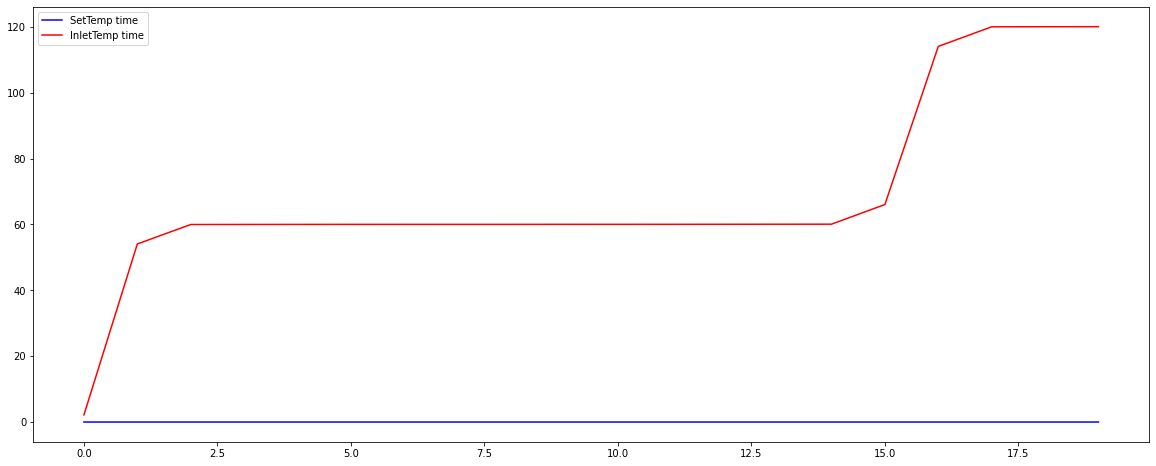

In [30]:
fig = plt.figure(figsize=(20, 8))

plt.plot(np.quantile(set_percentiles, np.arange(0, 0.2, 0.01)), "b-", label="SetTemp time")
plt.plot(np.quantile(inlet_percentiles, np.arange(0, 0.2, 0.01)), "r-", label= "InletTemp time")

plt.legend()
plt.show()

In [149]:
var_inlet = 0.01
var_set = 0.035

print(f"Inlet: {np.round( var_inlet / (var_inlet + var_set) * 100, 3)}")
print(f"Set: {np.round( var_set / (var_inlet + var_set) * 100, 3)}")


Inlet: 22.222
Set: 77.778


"SetTemp-sensor" ne contient que des int. Donc le pas minimum est de 1°C.

En moyenne sur la globalité, seulement 6.125% des écarts > 1°C, 12.664% des écart == 1.

Le temps minimum moyen entre le relevé du capteur "SetTemp-sensor" et le précendant vaut 0.008s

76.489% de ces écarts de temps < 2s qui est le temps minimum entre deux relevés de "InletTemp-sensor".

Je sais qu'au-dessus de 2s entre deux relevés (qui ont une valeur entre 16 et 32 inclus), il y a 19.035% de chance qu'il s'agisse de "SetTemp-sensor" et 80.965% qu'il s'agisse de "InletTemp-sensor".


###### Conclusion

* Si la valeur de "Value" est comprise entre 16 et 32, je suis sûr à **100%** qu'il s'agisse d'une valeur de "InletTemp-sensor" si c'est un nombre décimal.
* Si la valeur de "Value" est un entier:
  * Si la différence de temps entre le relevé et le précédent < 2s, je suis sûr à **100%** qu'il s'agisse de "SetTemp-sensor"
  * Sinon, je fais la différence entre l'ancienne valeur de "SetTemp-sensor" et le relevé actuel:
    * Si j'obtiens un nombre décimal, je suis sûr à **100%** qu'il s'agisse de "InletTemp-sensor"
    * Si j'obtiens 0, il y a **22.222%** de chance qu'il s'agisse de "InletTemp-sensor" et **77.778%** de "SetTemp-sensor"
    * Si c'est un autre nombre entier, il y a **72.244%** de chance qu'il s'agisse de "InletTemp-sensor" et **27.756%** de "SetTemp-sensor"

In [ ]:
str_val_df = pd.DataFrame([], columns= datas.columns)

for idx, row in datas.iterrows():
    value = row["Raw"]
    name = row["Name"]
    if type(value) == np.float64:
        if interv_listes[name][0]<= value <= interv_listes[name][1]:
            df = pd.concat([df, row])
    elif type(value) == str:
        if value in interv_listes[name]:
            df = pd.concat([df, row])
